# IBM/Coursera Capstone Project - The Battle of the Neighborhoods (Week 2)
### Open a new restaurant in Madrid, Spain

## Table of contents
* [Introduction: Business Problem](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results and Discussion](#Results)
* [Conclusion](#Conclusion)

## Introduction: Business Problem (from week 1)<a name="Introduction"></a>

Since I have not much time to think of an interesting new idea or problem for this Capstone Project, I will take advantage of one of the proposals given in the instructions: In a city of my choice I will perform a brief research to have an idea where I would recommend to open a restaurant.

The city where I actually live is **Madrid (Spain)**. I may have a subjective lens of the venues I love and with the help of Data Science I can put to the test my knowledge of my own city. Furthermore, I will be able to obtain some objective insights of the general situation and potential of the restaurant business here. Madrid is the most important air hub between South America and Europe as well as a cultural, historical and financial centre, so it still presents lots of development possibilities.

I have been to many asian countries and have experienced and enjoyed their amazing local cuisines. Madrid is packed with spanish food venues and also there are many asian food venues too but, however, very few from some particular food styles and the good ones I know are mainly in the city center and are slightly overpriced from my point of view. 

To focus, this project will also be targeted to stakeholders interested in opening a **thai restaurant** in **Madrid (Spain)**, searching for areas with no thai food available in vicinity and see whether there is still some niche areas in the city centre.

With the help of the data analysis, not only me but also other potential stakeholders will have an objective view of the existent venues and also of the location possibilities of starting a new restaurant business. 

## Data  (from week 1)<a name="Data"></a>

Tourists usually associate the location of Madrid centre with "Puerta de Sol" (old town) but as a local I prefer "Plaza de Cibeles" (location of the City Hall) since it lays not only more centered to the actual urbanistic layout but also it is an important traffic point, where the two biggest avenues cross. According to Wikipedia is in 40°25′08″N 3°41′32″W

Some data regarding the neigborhoods or districts from Madrid (location, population, etc) will be scrapped from the Wikipedia (i.e., https://en.wikipedia.org/wiki/Districts_of_Madrid)

In order to assess the restaurant business situation described, I leverage the Foursquare data from its API to explore or compare some statistics related to the venues of the given neighborhoods of Madrid (i.e. ratings, location, etc). 

Let's start downloading the dataset.

In [1]:
#install required libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

print('Libraries installed.')

     |████████████████████████████████| 102kB 9.2MB/s ta 0:00:011
     |████████████████████████████████| 102kB 13.6MB/s ta 0:00:01
Libraries installed.


In [2]:
#import libraries and their usual re-namings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# helps converting an address into its latitude and longitude
from geopy.geocoders import Nominatim 
import geocoder

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering module of scikit
from sklearn.cluster import KMeans

# map rendering library
import folium
from folium import plugins
from folium.plugins import HeatMap

# helps scrapping data from Wikipedia
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


## Methodology <a name="Methodology"></a>

After obtaining the raw neighborhood data and perform some filtering of the relevant information, the python geocoder library may provide the geographical coordinates of these districts.

I make use of the k-means clustering algorithm to perform the task.

Afterwards, with the help of the Folium library I will draw a few maps that might provide some visual insight for my personal use or other potential stakeholders.

#### Get the geocoordinates of Plaza de Cibeles (what I consider "my centre" of Madrid)

In [3]:
center_address = 'Plaza de Cibeles, Madrid'

geolocator = Nominatim(user_agent="Madrid_explorer")
location = geolocator.geocode(center_address)
latitude = location.latitude
longitude = location.longitude
my_Madrid_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(center_address, latitude, longitude))

The geograpical coordinate of Plaza de Cibeles, Madrid are 40.4195036, -3.6927366.


#### Obtain neighborhood data of Madrid

In [4]:
# read Madrid district data from Wikipedia
url = "https://en.wikipedia.org/wiki/Districts_of_Madrid"

# I was not able to use pandas read_html since I got the error
# "This article possibly contains original research..." without filling the dataframe
#df = pd.read_html('https://en.wikipedia.org/wiki/Districts_of_Madrid')[0]
#df.head()

#therefore I used BeautifulSoup
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

districtName = []
districtArea = []
districtPopulation = []
districtDensity = []
districtWards = []
wards = []

irow = 0
for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population" in header:
        i = 0
        for td in row.find_all("td"):
            # The variable "i" is the column index in the table
            i+=1
#            print("===td:", i, td.text)
            if i==2:
                districtName.append(td.text.replace("\n",""))
            if i==3:
                districtArea.append(td.text.replace("\n",""))
            if i==4:
                districtPopulation.append(td.text.replace("\n",""))    
            if i==5:
                districtDensity.append(td.text.replace("\n",""))    
            if i==7:
                wardnames = re.sub(r" ?\([^)]+\)", ",", td.text.replace("\n",""))
                wards_district = wardnames.split(",")
                # This removes an empty space at the end
                wards_district = list(filter(None, wards_district))
                districtWards.append(wards_district)
                for ward in wards_district:
                    wards.append(ward)    
                i=0

#print(*districtName, sep = "\n")
df_district = pd.DataFrame({"District": districtName, "Area": districtArea, 'Density':districtDensity,
                            "Population": districtPopulation, "Wards": districtWards})
#df_district = pd.DataFrame(list(zip(districtName, districtArea, districtPopulation, districtDensity, districtWards)), 
#               columns =['District', 'Area', 'Population', 'Density', 'Wards']) 
#df_district.head()

#print("There are {} districts in Madrid".format(df_district.shape[0]))


In [5]:
def getDistrict(row):
    for i in range(df_district.shape[0]):
        if row["Neighborhood"] in  df_district.iloc[i].Wards:
            return pd.Series([df_district.iloc[i].District, df_district.iloc[i].Density], index = ['District','Density'])

#other dataframe for the neighborhoods themselves
df_neighborhood = pd.DataFrame({"Neighborhood": wards})

df_neighborhood[["District","Density"]] = df_neighborhood.apply(getDistrict, axis=1)
print(len(df_neighborhood))

131


#### Get geographical coordinates of these neighborhoods of Madrid

This is obtained by means of the geocoder library
(it takes roughly a couple of minutes)

In [6]:
# append Madrid and Spain to get the location
madrid_address = 'Madrid, Spain'

# function to get coordinates
def get_LatLng(neighborhood):
    # initialize your variable to None
    lat_long_coords = None
    # loop until you get the coordinates
    while(lat_long_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood, madrid_address))
        lat_long_coords = g.latlng
    return lat_long_coords

coords = [ get_LatLng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of a few neighborhoods are as below")
df_neighborhood.head(12)


Geographical coordinates of a few neighborhoods are as below


,Neighborhood,District,Density,Latitude,Longitude
0,Palacio,Centro,252.34,40.41517,-3.71273
1,Embajadores,Centro,252.34,40.40803,-3.70067
2,Cortes,Centro,252.34,40.41589,-3.69636
3,Justicia,Centro,252.34,40.42479,-3.69308
4,Universidad,Centro,252.34,40.42565,-3.70726
5,Sol,Centro,252.34,40.41802,-3.70577
6,Imperial,Arganzuela,235.16,40.40833,-3.71865
7,Acacias,Arganzuela,235.16,40.40137,-3.70669
8,Chopera,Arganzuela,235.16,40.39536,-3.69833
9,Legazpi,Arganzuela,235.16,40.38702,-3.68990


#### Create a map of Madrid with the neighborhoods on it

This is obtained using the Folium library

In [7]:
#create map of Madrid neighborhoods using latitude and longitude values
map_Madrid = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Madrid)  
    
map_Madrid


#### Load venues to compare neighborhoods in Madrid

I will use Foursquare API for getting lists of venues of these neighborhoods within 1km to their center.

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the URL with the request for the API
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the request with GET
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a dataframe
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 298 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Palacio,40.41517,-3.71273,Plaza de la Villa,4adcda37f964a5201e3c21e3,40.415409,-3.710391,200,Historic Site
1,Palacio,40.41517,-3.71273,Santa Iglesia Catedral de Santa María la Real ...,4adcda38f964a520523c21e3,40.415767,-3.714516,165,Church
2,Palacio,40.41517,-3.71273,Plaza de La Almudena,4fa1419ee4b0b6a5a232eb53,40.416320,-3.713777,155,Plaza
3,Palacio,40.41517,-3.71273,Cervecería La Mayor,4c321c9816adc9281693c19c,40.415218,-3.712194,45,Beer Bar
4,Palacio,40.41517,-3.71273,Zuccaru,593be9b516fa0435e49bbc2f,40.417179,-3.711674,240,Ice Cream Shop


In [10]:
print('Top 10 distinct venue counts are these:')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:295]

Top 10 distinct venue counts are these:


,Count
VenueCategory,
Spanish Restaurant,385
Restaurant,231
Tapas Restaurant,161
Bar,155
Hotel,113
Park,112
Café,103
Pizza Place,100
Supermarket,94


#### Filter the restaurants out of all venues

Since thai restaurants are very few (only six) and it is not difficult to avoiding be near one of them, I consider it can provide some value to be away of other asian restaurants.

In [11]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
asian_restaurant_list = ['Chinese Restaurant', 'Asian Restaurant', 'Japanese Restaurant', 
                         'Sushi Restaurant','Indian Restaurant','Korean Restaurant','Thai Restaurant',
                         'Persian Restaurant','Udon Restaurant']

# Actual filtering (whether is asian or not)

neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
asian_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(asian_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(asian_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of asian restaurants:', len(asian_restaurants['VenueId'].unique()),
      ' ({:.2f}%)'.format(len(asian_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 1601
Total number of asian restaurants: 173  (10.81%)


31 neighborhoods do not have any asian restaurant


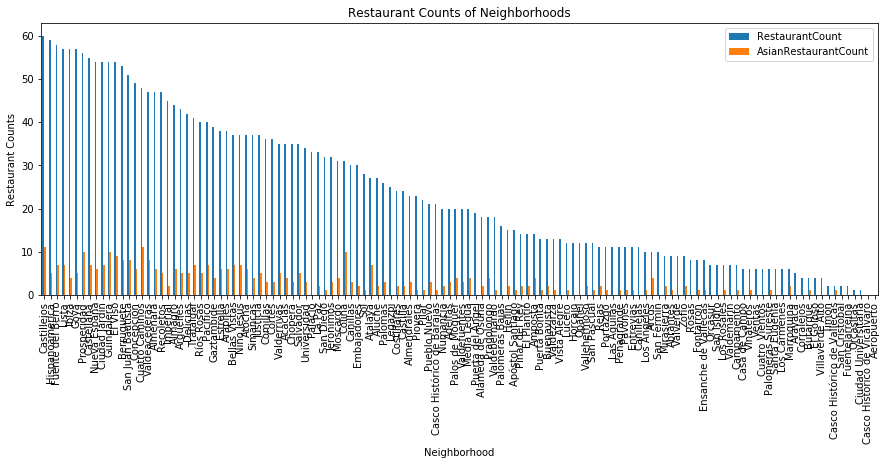

In [12]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of asian restaurants in each Neighborhood
df_asian_rest_counts =  asian_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "AsianRestaurantCount"})[['AsianRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(asian_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_asian_rest_counts = df_asian_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'AsianRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_asian_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_asian_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any asian restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','AsianRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In this graph we can see that:
* Castillejos (Tetuán district) has the highest restaurant count.
* Palacio (Centro district) has many restaurants but very few asians.
* Legazpi (Arganzuela district) has roughly an average number of restaurants but no asians at all.
* In total, there are 33 neighborhoods not having any asian restaurant.
    
### Get an overall rating for the restaurants
With the help of the Foursquare API (this also takes roughly a couple of minutes)

In [14]:
def getVenueRatings(venues):
    
    ratings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        ratings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(ratings)
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_ratings = getVenueRatings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_ratings.head()


,VenueId,VenueRating,VenueLikes
0,52c5c362498e59d832d546aa,None,None
1,4adcda3bf964a5207c3d21e3,None,None
2,4df2816d7d8b18e1722b9bcd,None,None
3,58ff9e7c6fd626300708b2ab,None,None
4,4adcda3af964a5205e3d21e3,None,None


In [15]:
#merge ratings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_ratings)
neighborhood_restaurants.head()

#merge ratings to asian restaurants 
asian_restaurants = asian_restaurants.merge(restaurants_ratings)
asian_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Embajadores,40.40803,-3.70067,Yoka Loka,4f2d2e4ae4b0124ab827520d,40.411615,-3.698693,432,Sushi Restaurant,None,None
1,Cortes,40.41589,-3.69636,Yoka Loka,4f2d2e4ae4b0124ab827520d,40.411615,-3.698693,515,Sushi Restaurant,None,None
2,Embajadores,40.40803,-3.70067,Pui Thai Tapas,4d55a13048ea6ea8fb42d7a3,40.404475,-3.696692,519,Thai Restaurant,None,None
3,Acacias,40.40137,-3.70669,Pui Thai Tapas,4d55a13048ea6ea8fb42d7a3,40.404475,-3.696692,915,Thai Restaurant,None,None
4,Palos de Moguer,40.40301,-3.69358,Pui Thai Tapas,4d55a13048ea6ea8fb42d7a3,40.404475,-3.696692,310,Thai Restaurant,None,None


#### Display the restaurants on a heat map of Madrid

I will create a map displaying a heat map (density of restaurants) in order to get some visual meaningfull information.

Moreover, I will show show district borders of Madrid on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from my selected center of Madrid.

Red markers are asian restaurants

Blue markers are asian restaurants with rating < 7.

In [16]:
madrid_center = [latitude, longitude]
map_restaurant= folium.Map(location=madrid_center, zoom_start=13)
df_neighborhood_noAsianRest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_Madrid) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(madrid_center).add_to(map_Madrid)
folium.Circle(madrid_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(madrid_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(madrid_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(madrid_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(asian_restaurants['VenueLatitude'], asian_restaurants['VenueLongitude'], asian_restaurants['Neighborhood'], asian_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = asian_restaurants[asian_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

Viewing the heat map, we can see that:
* The restaurant business center seems to be even more to the east and north that what I have supposed (which is already 2km to the east in relation to the center of the old town, i.e. "Puerta del Sol")
* There are not many restaurants outside the 6km circle.
* Asian restaurants are superimposed with red and blue dots, being the latest with rating < 7.
* Most asian restaurants are in the north-east quadrant of the city.
* THere are very few asian restaurants in the southwest area.

#### Display the neighborhoods not having asian restaurants

Cyan markers are used to show these neigborhoods (better visible when zooming out)

In [17]:
madrid_center = [latitude, longitude]
map_restaurant= folium.Map(location=madrid_center, zoom_start=13)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_Madrid) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(madrid_center).add_to(map_Madrid)
folium.Circle(madrid_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(madrid_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(madrid_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(madrid_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

### Cluster the neighborhoods by means of  agglomerative clustering


In [18]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns = ['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]
# remove neighborhood column laying in the middle (don't know why)
venues_grouped = venues_grouped.loc[:,~venues_grouped.columns.duplicated()]

print("{} neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

128 neighborhoods' venue category are shown in 297 columns as below


,Neighborhood,Historic Site,Church,Plaza,Beer Bar,Ice Cream Shop,Restaurant,Palace,Market,Tapas Restaurant,French Restaurant,Opera House,Garden,Performing Arts Venue,Café,Lounge,Other Nightlife,Spanish Restaurant,Wine Bar,Gym / Fitness Center,Park,Pastry Shop,Hotel,Cocktail Bar,American Restaurant,Vegetarian / Vegan Restaurant,Rock Club,Bistro,Road,Bar,Chocolate Shop,Food & Drink Shop,Gastropub,Bookstore,Mediterranean Restaurant,Coffee Shop,Hostel,Indie Movie Theater,Candy Store,History Museum,Pizza Place,Gym,Gourmet Shop,Creperie,Dessert Shop,Cosmetics Shop,Gay Bar,Other Event,Wine Shop,Theater,Art Gallery,Event Space,Seafood Restaurant,Argentinian Restaurant,Liquor Store,Circus,Sushi Restaurant,Brewery,Breakfast Spot,Movie Theater,Pub,Thai Restaurant,Art Museum,Bakery,Food Truck,Mexican Restaurant,Grocery Store,Italian Restaurant,Toy / Game Store,Exhibit,Pie Shop,Cuban Restaurant,Beer Store,Museum,Jazz Club,Farmers Market,Fountain,Roof Deck,Monument / Landmark,Casino,Electronics Store,Government Building,Japanese Restaurant,General Entertainment,City Hall,Hotel Bar,Clothing Store,BBQ Joint,Flower Shop,Burger Joint,Sporting Goods Shop,Accessories Store,Beer Garden,Boutique,Furniture / Home Store,Shoe Store,Miscellaneous Shop,Supermarket,Mobile Phone Shop,Donut Shop,Peruvian Restaurant,Men's Store,Cheese Shop,Chinese Restaurant,Swiss Restaurant,Hobby Shop,Cupcake Shop,Rental Service,Salon / Barbershop,Embassy / Consulate,South American Restaurant,Greek Restaurant,Hot Dog Joint,Korean Restaurant,Spa,Soccer Stadium,Racetrack,Music Venue,Big Box Store,Concert Hall,Latin American Restaurant,Photography Lab,Indie Theater,Playground,Gymnastics Gym,Bridge,Theme Restaurant,Beach,Skate Park,Soccer Field,Trade School,Pool,Flea Market,Shopping Mall,Tattoo Parlor,Falafel Restaurant,Science Museum,Multiplex,Planetarium,Portuguese Restaurant,Fast Food Restaurant,Metro Station,Asian Restaurant,Arepa Restaurant,Sandwich Place,Platform,Train Station,Polish Restaurant,Gift Shop,Indian Restaurant,Snack Place,Diner,Dog Run,Board Shop,Athletics & Sports,Football Stadium,Eastern European Restaurant,Pet Store,Sports Club,Tea Room,Food,Deli / Bodega,Used Bookstore,Convenience Store,Basketball Stadium,Juice Bar,Steakhouse,North Indian Restaurant,Scenic Lookout,Thrift / Vintage Store,Jewelry Store,Perfume Shop,College Classroom,Ramen Restaurant,Discount Store,Persian Restaurant,Department Store,Taco Place,Women's Store,Dive Shop,Pool Hall,Bed & Breakfast,Music Store,Paella Restaurant,Salad Place,Burrito Place,Bagel Shop,Coworking Space,Turkish Restaurant,German Restaurant,Middle Eastern Restaurant,Brazilian Restaurant,Fried Chicken Joint,Gun Range,Gym Pool,Moroccan Restaurant,Health & Beauty Service,Sports Bar,Comedy Club,Fish Market,Comfort Food Restaurant,Arcade,Nightclub,Motorcycle Shop,Frozen Yogurt Shop,Skating Rink,Fish & Chips Shop,Bowling Alley,Travel Lounge,Tennis Court,Medical Lab,Pharmacy,Kebab Restaurant,Yoga Studio,Resort,Art Studio,Library,Vietnamese Restaurant,Karaoke Bar,Massage Studio,Basketball Court,Dumpling Restaurant,Boxing Gym,Fabric Shop,Food Stand,Venezuelan Restaurant,Building,Track,Golf Course,Residential Building (Apartment / Condo),Comic Shop,Video Game Store,Udon Restaurant,Sculpture Garden,New American Restaurant,IT Services,Bus Line,Construction & Landscaping,Track Stadium,Paper / Office Supplies Store,College Gym,Zoo,Aquarium,Theme Park Ride / Attraction,Theme Park,Farm,Buffet,College Residence Hall,College Cafeteria,Student Center,Stadium,Memorial Site,Arts & Entertainment,Bike Shop,Lake,Irish Pub,Bus Station,Airport,Outlet Mall,Baby Store,Colombian Restaurant,Moving Target,Dance Studio,Trail,Noodle House,Bubble Tea Shop,Community College,Camera Store,Gas Station,Optical Shop,Food Court,Kids Store,Office,Food Service,Butcher,Molecular Gastronomy Restaurant,Bus Stop,Drive-in Theater,Music School,Outdoors & Recreation,Garden Center,Cafeteria,Light Rail Station,Smoke Shop,College Auditorium,Cultural Center,Business Service

In [19]:
# create a new dataframe with most common venue categories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

venues_grouped.loc[:,'Neighborhood']
for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind,'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind,'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()


,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,Pacífico,100,Spanish Restaurant,Bar,Grocery Store,Supermarket,Museum
1,Pavones,26,Spanish Restaurant,Grocery Store,Gym / Fitness Center,Bakery,Restaurant
2,Abrantes,26,Bar,Park,Metro Station,Plaza,Fast Food Restaurant
3,Acacias,100,Tapas Restaurant,Bar,Park,Pizza Place,Plaza
4,Adelfas,41,Spanish Restaurant,Museum,Italian Restaurant,Gym,Peruvian Restaurant


#### Cluster and find similarities among neighborhoods
I use hierarchical agglomerative clustering to compare the neighborhoods

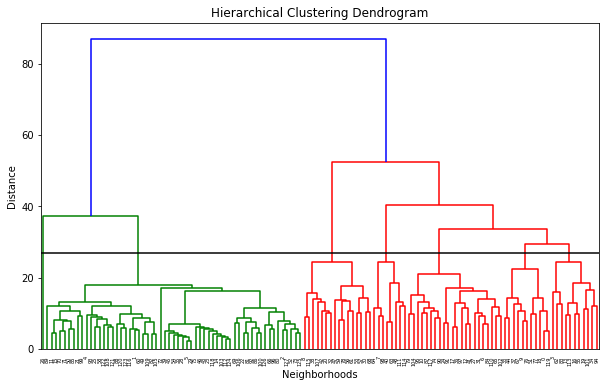

In [24]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=27, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 7 clusters (cut at distance of 27, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [27]:
from sklearn.cluster import AgglomerativeClustering

kclusters = 7
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,District,Density,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Palacio,Centro,252.34,40.41517,-3.71273,2,Tapas Restaurant,Spanish Restaurant,Plaza
1,Embajadores,Centro,252.34,40.40803,-3.70067,1,Café,Plaza,Coffee Shop
2,Cortes,Centro,252.34,40.41589,-3.69636,1,Restaurant,Plaza,Hotel
3,Justicia,Centro,252.34,40.42479,-3.69308,1,Restaurant,Plaza,Hotel
4,Universidad,Centro,252.34,40.42565,-3.70726,1,Bookstore,Plaza,Tapas Restaurant


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, District ,Density  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['District'],venues_cluster['Density']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(District) + ' ' + str(Density), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(madrid_center).add_to(map_clusters)
folium.Circle(madrid_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(madrid_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(madrid_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(madrid_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

* Cluster 0: red
* Cluster 1: purple
* Cluster 2: blue
* Cluster 3: cyan
* Cluster 4: yellow
* Cluster 5: green
* Cluster 6: orange

In [31]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                  Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                      
0                   Restaurant                                     1
                    Spanish Restaurant                            15
1                   Bookstore                                      1
                    Café                                           1
                    Plaza                                          1
                    Restaurant                                     5
2                   Bar                                            1
                    Plaza                                          1
                    Restaurant                                     1
                    Spanish Restaurant                             5
                    Tapas Restaurant                               3
3                   Airport Service                                1
                    Bar           

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Bar                                          1
                    Hotel                                        1
                    Restaurant                                  10
                    Seafood Restaurant                           1
                    Spanish Restaurant                           1
                    Tapas Restaurant                             2
1                   Hotel                                        1
                    Plaza                                        4
                    Restaurant                                   1
                    Spanish Restaurant                           2
2                   Bar                                          3
                    Coffee Shop                                  1
                    Restaurant                                   1
                    Spanish Restaurant                           3
                    Tapas Restaurant                             3
3                   Airport                                      1
                    Athletics & Sports                           2
                    Bar                                          5
                    Beer Garden                                  1
                    Breakfast Spot                               1
                    Brewery                                      1
                    Café                                         1
                    Coffee Shop                                  1
                    College Residence Hall                       1
                    Cupcake Shop                                 1
                    Diner                                        1
                    Exhibit                                      1
                    Fast Food Restaurant                         1
                    Grocery Store                                4
                    Gym                                          2
                    Italian Restaurant                           1
                    Museum                                       1
                    Optical Shop                                 1
                    Park                                         5
                    Pizza Place                                  8
                    Plaza                                        2
                    Restaurant                                   4
                    Sandwich Place                               1
                    Seafood Restaurant                           2
                    Spanish Restaurant                           5
                    Supermarket                                  3
                    Tapas Restaurant                             2
4                   Exhibit                                      1
5                   Bar                                          2
                    Fast Food Restaurant                         1
                    Grocery Store                                1
                    Hotel                                        2
                    Italian Restaurant                           3
                    Park                                         1
                    Pharmacy                                     1
                    Restaurant                                   4
                    Spanish Restaurant                           6
                    Tapas Restaurant                             1
6                   Bar                                          8
                    Restaurant                                   2
                    Seafood Restaurant                           1

### Discussion
First of all, cluster 4 is an outlier consisting of an exhibition area without possibilities for a restaurant (it could have been cleaned from the initial data).

It can be see that clusters 1 and 2 have relatively less restaurants topping the ranking of venues, whereas clusters 0, 3, 5 and 6 love all kind of food places. We can see that in the heat map too.

Cluster 3 especially likes chinese restaurants. It would require further data to perform a research if this is because of other neigborhood aspect or even in that case it could be a good location for a thai restaurant. Besides, these are mainly neighborhoods located in the outskirts and therefore the real estate costs are expected to be lower.

In order to obtain a final conclusion, I will take a look to the neighborhoods in these clusters (1 and 2) and sort them in terms of population density.

Population density is the only data available to perform further decisions. A real analysis would consider the public transport possibilities, the purchasing power of the area, etc, but this is not available for this work.

Therefore, not having other data, I would consider of value to be in a neighborhood with high population density, thus having more potential diners nearby the location.


In [43]:
#venues_cluster
venues_cl12 = venues_cluster.loc[(venues_cluster['NeighborhoodCluster']==1) | (venues_cluster['NeighborhoodCluster']==2) ]
venues_cl12 = mydf.sort_values(by=['Density'], ascending=False)
venues_cl12

,Neighborhood,District,Density,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
40,Almagro,Chamberí,293.64,40.43296,-3.69153,1,Restaurant,Spanish Restaurant,Hotel
39,Trafalgar,Chamberí,293.64,40.43303,-3.70003,2,Plaza,Restaurant,Spanish Restaurant
38,Arapiles,Chamberí,293.64,40.43286,-3.70840,2,Bar,Coffee Shop,Café
37,Gaztambide,Chamberí,293.64,40.43490,-3.71551,2,Spanish Restaurant,Bar,Tapas Restaurant
41,Ríos Rosas,Chamberí,293.64,40.44475,-3.69511,2,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center
31,Bellas Vistas,Tetuán,286.13,40.45457,-3.70552,2,Spanish Restaurant,Bar,Seafood Restaurant
19,Recoletos,Salamanca,266.67,40.42530,-3.68651,1,Restaurant,Spanish Restaurant,Hotel
1,Embajadores,Centro,252.34,40.40803,-3.70067,1,Café,Plaza,Coffee Shop
5,Sol,Centro,252.34,40.41802,-3.70577,1,Plaza,Restaurant,Tapas Restaurant
2,Cortes,Centro,252.34,40.41589,-3.69636,1,Restaurant,Plaza,Hotel


### Conclusion

Considering this last table and to conclude this report, I have a couple of proposals: Neighborhood **Arapiles** (in cluster 2) and **Embajadores** (in cluster 1): it belongs to the selected clusters, have a large population density and the current businesses seem not to be dominated by restaurants.

